# AlexNet Implementation  
  
    
      
      
  
This Model implements the model described in the [**AlexNet paper.**](https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf)    
  
  AlexNet trained a large, deep convolutional neural network to classify the **1.2 million high-resolution images** in the ImageNet LSVRC-2010 contest into the 1000 different classes.  
  It has **60 million parameters and 650,000 neurons**, consists of five convolutional layers, some of which are followed by max-pooling layers, and three fully-connected layers with a final 1000-way softmax
  
The model is implemented in **Keras with tensorflow backend.**  
  
<font color='blue'>Below Cell imports the required python libraries:

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import pydotplus
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from keras.utils import plot_model
from keras.utils import to_categorical
from keras.preprocessing import image as keras_image
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

from keras.applications.inception_v3 import InceptionV3, preprocess_input
import scipy
from scipy import misc

Using TensorFlow backend.


# Load and Explore the Data

For this Model, we are using the database of various **fashion products** sorted by two labels **product type** and **brands**.  
This dataset was taken from the [kaggle.](https://www.kaggle.com/olgabelitskaya/style-color-images)  

The dataset consists of :
+ **894 color images (150x150x3)**- 715 Training Images and 179 Test Images
+ **7 brands and 10 products**

and the file with labels is style.csv. Photo files are in the .png format and the labels are integers and values.  
  
Since there are two labels, we can train our model to classify any one of them...here we trained it to detect **Product Type**


Run the following cell to load the dataset labels:

In [2]:
data = pd.read_csv("data/style.csv")
print("Brand Names:",set(data['brand_name']))
print("\nProduct Types:",set(data['product_name']))

Brand Names: {'Versace', 'Yves Saint Laurent', 'Christian Dior', 'Gucci', 'Chanel', 'Christian Louboutin', 'Dolce & Gabbana'}

Product Types: {'watches', 'necklace', 'lipstick', 'shoes', 'nail polish', 'ring', 'earrings', 'boots', 'bracelet', 'handbag'}


<font color='blue'>Following cell defines the functions for converting the image data into tensors for input to Model's first layer:

In [3]:
# Function for processing an image
def image_to_tensor(img_path):
    img = keras_image.load_img("data/style/" + img_path, target_size=(150, 150))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)
# Function for creating the data tensor
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

ImageFile.LOAD_TRUNCATED_IMAGES = True

<font color='blue'>Run below cell to convert data labels to matrices and load the images.

In [4]:
#create tensors
brands = data['brand_label'].as_matrix()
products = data['product_label'].as_matrix()
images = data_to_tensor(data['file']);

100%|███████████████████████████████████████████████████████████████████████████████| 894/894 [00:02<00:00, 440.94it/s]


<font color='blue'>Initial Dimensions of all Vectors:

In [5]:
#Shapes
print ('Image shape:', images.shape)
print ('Brand shape', brands.shape)
print ('Product shape', products.shape)

Image shape: (894, 150, 150, 3)
Brand shape (894,)
Product shape (894,)


<font color='blue'>The following cell packs the images and labels into h5 format for efficient processing

In [6]:
# Create the tensor file
with h5py.File('data/StyleColorImages.h5', 'w') as f:
    f.create_dataset('images', data = images)
    f.create_dataset('brands', data = brands)
    f.create_dataset('products', data = products)
    f.close()
# Read the h5 file
f = h5py.File('data/StyleColorImages.h5', 'r')

# List all groups
keys = list(f.keys())

# Create tensors and targets
brands = np.array(f[keys[0]])
images = np.array(f[keys[1]])
products = np.array(f[keys[2]])

print ('Image shape:', images.shape)
print ('Brand shape', brands.shape)
print ('Product shape', products.shape)

Image shape: (894, 150, 150, 3)
Brand shape (894,)
Product shape (894,)


In [7]:
# Normalize tensors
images = images.astype('float32')/255
# One-hot encode the products
cat_products = to_categorical(products, 10)
cat_products.shape

(894, 10)

 <font color='blue'>Run below cell to look at a particular image from dataset...(You can change value of i for corresponding image).

Product:  shoes
Brand:  Christian Dior


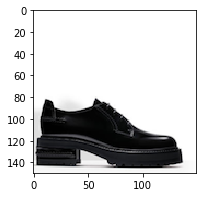

In [14]:
# Read and display a tensor using Matplotlib
i=526
print('Product: ', data['product_name'][i])
print('Brand: ', data['brand_name'][i])
plt.figure(figsize=(3,3))
plt.imshow(images[i]);

<font color='blue'>Normalize the image vectors and create one hot encodings:

Split the data into training and testing data, Here:
+ Training size is 80% of dataset : **715 images**
+ Testing size is 20% of dataset : **179 images**

In [15]:
# Split the data
x_train, x_test, y_train, y_test = train_test_split(images, cat_products, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
# Print the shape
print ("Training tensor's shape:", x_train.shape)
print ("Training target's shape", y_train.shape)
print ("Testing tensor's shape:", x_test.shape)
print ("Testing target's shape", y_test.shape)

Training tensor's shape: (715, 150, 150, 3)
Training target's shape (715, 10)
Testing tensor's shape: (179, 150, 150, 3)
Testing target's shape (179, 10)


# Model Description:  

Below Model uses **5 Convolution layers**:
+ First Conv layer use **96 Filters of size 11 x 11, strides: 4, No Padding and Relu activation**
+ First Conv layer use **256 Filters of size 5 x 5, Same Padding and Relu activation**
+ First Conv layer use **384 Filters of size 3 x 3, Same Padding and Relu activation**
+ First Conv layer use **384 Filters of size 3 x 3, Same Padding and Relu activation**
+ First Conv layer use **256 Filters of size 3 x 3, Same Padding and Relu activation**
  
There are **3 MaxPool layers**,in which:
+ Filter size : **3 x 3**
+ Strides : **2**

And **3 fully connected layers**:
+ First fully connected layer has **1024 hidden units** and uses **Relu activation**
+ Second fully connected layer has **1024 hidden units** and uses **Relu activation**
+ Third fully connected layer has **10 hidden units** and uses **Softmax activation**
  
  
After Convolution stages, The images are **flattened** and feeded to fully connected layers.

In [16]:
def cp_model():
    classifier = Sequential()
    #convolutional layer
    classifier.add(Conv2D(96, (11, 11), strides=4,input_shape = (150, 150, 3), activation = 'relu'))

    classifier.add(MaxPooling2D(pool_size = (3, 3),strides=2))
   
    classifier.add(Conv2D(256, (5, 5),padding='same',activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (3, 3),strides=2))
    classifier.add(Conv2D(384, (3, 3),padding='same',activation = 'relu'))
    classifier.add(Conv2D(384, (3, 3),padding='same',activation = 'relu'))
    classifier.add(Conv2D(256, (3, 3),padding='same',activation = 'relu'))
    classifier.add(MaxPooling2D(pool_size = (3, 3),strides=2))
    #Flattening
    classifier.add(Flatten())
    #Full connection
    classifier.add(Dense(units = 1024, activation = 'relu'))
    classifier.add(Dense(units = 1024, activation = 'relu'))
    classifier.add(Dense(units = 10, activation = 'softmax'))
    # Compiling the CNN
    classifier.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

cp_model = cp_model()

Now our model is ready to be trained on the traing set, Here we used:
+ No. of iterations: **5**
+ Size of mini batches: **16**  

<font color='blue'>Run the following cell to train the model on 5 iterations with a batch size of 16. 

In [ ]:
# Train the model
cp_model.fit(x_train, y_train,epochs=5, batch_size=16, verbose=1)

Epoch 1/5
715/715 [==============================] - ETA: 3:03 - loss: 2.2976 - acc: 0.125 - ETA: 2:08 - loss: 2.2976 - acc: 0.156 - ETA: 1:48 - loss: 2.2997 - acc: 0.166 - ETA: 1:37 - loss: 2.2977 - acc: 0.187 - ETA: 1:30 - loss: 2.2945 - acc: 0.225 - ETA: 1:25 - loss: 2.2954 - acc: 0.208 - ETA: 1:21 - loss: 2.2943 - acc: 0.196 - ETA: 1:17 - loss: 2.2937 - acc: 0.179 - ETA: 1:14 - loss: 2.2931 - acc: 0.173 - ETA: 1:12 - loss: 2.2916 - acc: 0.168 - ETA: 1:09 - loss: 2.2909 - acc: 0.164 - ETA: 1:07 - loss: 2.2910 - acc: 0.161 - ETA: 1:05 - loss: 2.2905 - acc: 0.173 - ETA: 1:02 - loss: 2.2895 - acc: 0.165 - ETA: 1:00 - loss: 2.2885 - acc: 0.175 - ETA: 58s - loss: 2.2892 - acc: 0.171 - ETA: 56s - loss: 2.2863 - acc: 0.17 - ETA: 54s - loss: 2.2846 - acc: 0.17 - ETA: 52s - loss: 2.2804 - acc: 0.19 - ETA: 50s - loss: 2.2798 - acc: 0.19 - ETA: 48s - loss: 2.2769 - acc: 0.19 - ETA: 46s - loss: 2.2769 - acc: 0.19 - ETA: 43s - loss: 2.2739 - acc: 0.19 - ETA: 41s - loss: 2.2746 - acc: 0.19 - ETA:

<font color='blue'>Evaluate the model on test set

In [27]:
preds = cp_model.evaluate(x_test, y_test, verbose=1)

179/179 [==============================] - ETA: 11 - ETA: 8 - ETA:  - ETA:  - ETA:  - 12s 66ms/step


In [28]:
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))

Loss = 14.67737143
Test Accuracy = 0.0893854749436


Here is a **summary** of the above model.    
  
  
It shows the **dimensions of output** at every layer and the **no. of parameters** at every layer.  
  
  Total trainable Parameters in the model: **5,195,146**

In [29]:
cp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 35, 35, 96)        34944     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 17, 17, 96)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 17, 17, 256)       614656    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 384)         885120    
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 384)         1327488   
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 256)         884992    
__________